In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

---

In [105]:
target = 'adrb1'

In [109]:
from Bio import SeqIO

def get_sequence_from_pdb(target_path):
    warnings.filterwarnings('ignore')
    recs = list(SeqIO.parse(target_path, "pdb-atom"))
    return recs[0]

seq = str(get_sequence(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/receptor.pdb').seq)

In [33]:
actives = Chem.SDMolSupplier(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/actives_final.sdf')
decoys = Chem.SDMolSupplier(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/decoys_final.sdf')

In [34]:
# Load model
from architectures import SimplePLMModel, SimpleCosine
from mol_feats import Morgan_f
from prot_feats import ProtBert_f
mol_f = Morgan_f()
prot_f = ProtBert_f()
# model = torch.load("../best_models/dti_dg_morganM_protbertP_bm_best_model.sav").cuda()
model = torch.load("../best_models/bindingdb_morgan_protbert_best_model.sav").cuda()

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

In [35]:
active_projections = []
decoy_projections = []

with torch.set_grad_enabled(False):
    for m in tqdm(actives):
        m_emb = mol_f(Chem.MolToSmiles(m)).cuda()
        m_proj = model.mol_projector(m_emb).detach().cpu().numpy()
        active_projections.append(m_proj)
    for m in tqdm(decoys):
        try:
            m_emb = mol_f(Chem.MolToSmiles(m)).cuda()
            m_proj = model.mol_projector(m_emb).detach().cpu().numpy()
            decoy_projections.append(m_proj)
        except Exception as e:
            continue
    seq_proj = model.prot_projector(prot_f(str(seq)).cuda()).cpu().numpy()

  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/15958 [00:00<?, ?it/s]

In [36]:
from sklearn.manifold import TSNE
all_projections = np.concatenate([active_projections,decoy_projections,[seq_proj]],axis=0)
project_tsne = TSNE(metric="cosine").fit_transform(all_projections)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.

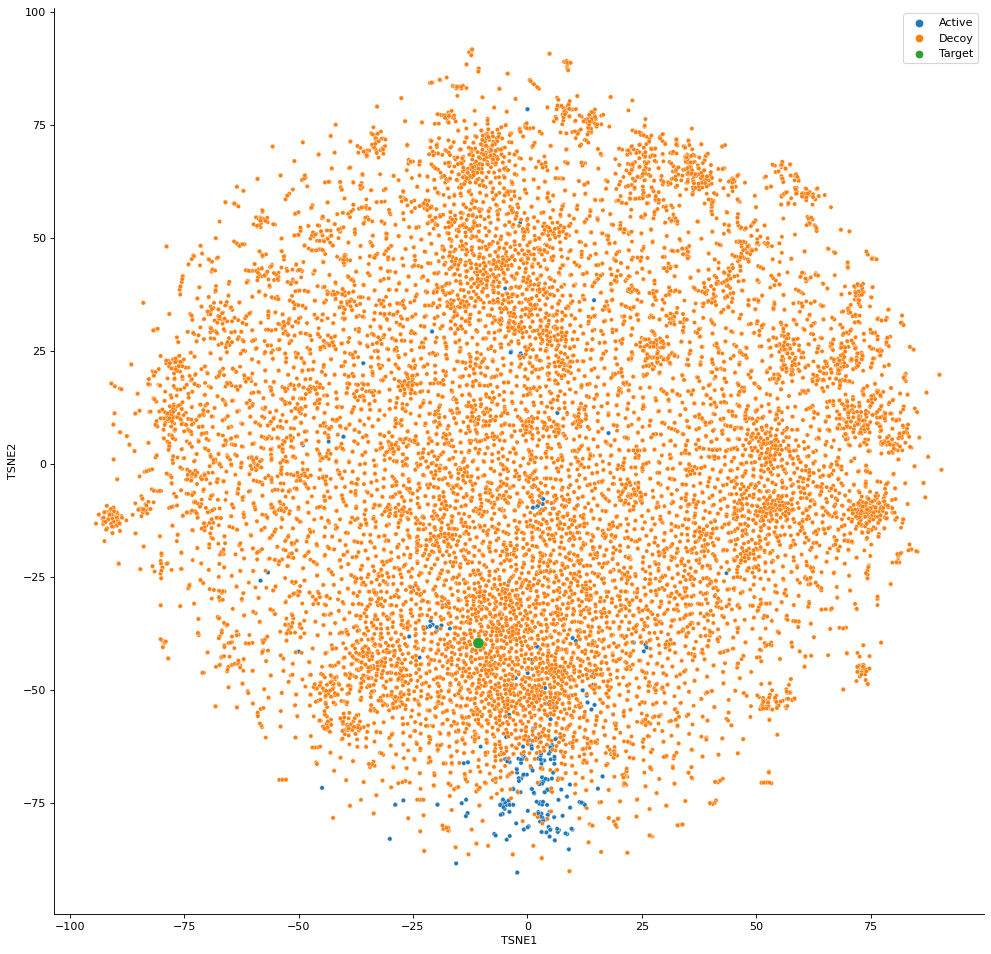

In [37]:
hue = ['Active']*len(active_projections)+['Decoy']*len(decoy_projections)+['Target']
size = [15]*len(active_projections)+[15]*len(decoy_projections)+[100]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(x=project_tsne[:,0],
                y=project_tsne[:,1],
                hue=hue,
                s=size
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
sns.despine()
plt.show()

In [38]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine
cosine_sim = CosineSimilarity(dim=0)

In [39]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine
cosine_sim = CosineSimilarity(dim=0)

active_scores = []
decoy_scores = []

pProj = torch.from_numpy(seq_proj).cuda()

with torch.set_grad_enabled(False):
    for mProj in tqdm(active_projections):
        affin = cosine_sim(pProj,torch.from_numpy(mProj).cuda()).cpu().numpy()
        active_scores.append(float(affin))
    for mProj in tqdm(decoy_projections):
        affin = cosine_sim(pProj,torch.from_numpy(mProj).cuda()).cpu().numpy()
        decoy_scores.append(float(affin))

  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/15958 [00:00<?, ?it/s]

In [40]:
df = pd.DataFrame({"scores":active_scores + decoy_scores,"label":(['active']*len(active_scores))+(['decoy']*len(decoy_scores))})

In [41]:
df

,scores,label
0,0.331547,active
1,0.250043,active
2,0.331547,active
3,0.250043,active
4,0.559042,active
...,...,...
16411,0.500771,decoy
16412,0.353025,decoy
16413,0.182055,decoy
16414,0.220934,decoy


In [42]:
import scipy
stat, pvalue = scipy.stats.ttest_ind(df[df['label'] == 'active']['scores'], df[df['label'] == 'decoy']['scores'],alternative='greater')
(stat, pvalue)

(28.28639282850245, 3.289785957350113e-172)

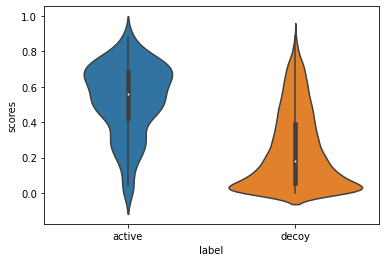

In [43]:
sns.violinplot(data=df, x='label', y='scores')
plt.show()

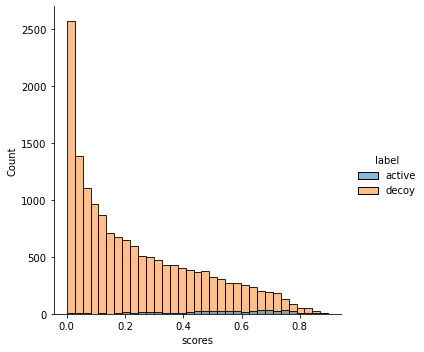

In [44]:
sns.displot(data=df,x='scores',hue='label')
plt.show()

---

# Process and clean all targets

In [95]:
from rdkit.Chem import PandasTools
import os

In [96]:
targets = os.listdir('/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/')

In [111]:
active_dfs = {}
decoy_dfs = {}
link_dfs = {}

for tid in tqdm(targets):
    tseq = str(get_sequence_from_pdb(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{tid}/receptor.pdb').seq)
    actives_frame = PandasTools.LoadSDF(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{tid}/actives_final.sdf',
                                        smilesName='SMILES',molColName=None,includeFingerprints=True).drop_duplicates()
    decoys_frame = PandasTools.LoadSDF(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{tid}/decoys_final.sdf',
                                        smilesName='SMILES',molColName=None,includeFingerprints=True).drop_duplicates()

    links = []
    for _, row in actives_frame.iterrows():
        links.append((tid, tseq, row.ID, row.SMILES, 1))
    for _, row in decoys_frame.iterrows():
        links.append((tid, tseq, row.ID, row.SMILES, 0))
    df = pd.DataFrame(links)
    
    active_dfs[tid] = actives_frame
    decoy_dfs[tid] = decoys_frame
    link_dfs[tid] = df

  0%|          | 0/102 [00:00<?, ?it/s]

[11:34:04] Explicit valence for atom # 7 N, 5, is greater than permitted
[11:34:04] ERROR: Could not sanitize molecule ending on line 3875828
[11:34:04] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted
[11:35:37] Explicit valence for atom # 7 N, 5, is greater than permitted
[11:35:37] ERROR: Could not sanitize molecule ending on line 586033
[11:35:37] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted
[11:36:14] Explicit valence for atom # 7 N, 5, is greater than permitted
[11:36:14] ERROR: Could not sanitize molecule ending on line 1169873
[11:36:14] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted
[11:36:27] Explicit valence for atom # 9 N, 5, is greater than permitted
[11:36:27] ERROR: Could not sanitize molecule ending on line 1034433
[11:36:27] ERROR: Explicit valence for atom # 9 N, 5, is greater than permitted


In [112]:
full_links = pd.concat(link_dfs.values()).reset_index(drop=True)
full_links.columns = ['Target_ID','Target_Seq','Molecule_ID','Molecule_SMILES','Label']

In [113]:
full_links

,Target_ID,Target_Seq,Molecule_ID,Molecule_SMILES,Label
0,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
1,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)C1CCCc2ccc[nH...,1
2,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089845,[NH3+]C/C=C/CN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
3,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089845,[NH3+]C/C=C/CN(Cc1nc2ccccc2[nH]1)C1CCCc2ccc[nH...,1
4,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089846,[NH3+]CC#CCN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
...,...,...,...,...,...
1438330,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63372157,CC(NC(=O)C(CC1=c2ccccc2=[NH+]C1)N1C(=O)N=C2C=C...,0
1438331,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63373267,CC(NC(=O)C(CC1=c2ccccc2=[NH+]C1)N1C(=O)N=C2C=C...,0
1438332,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63373939,O=C(CCN1C(=O)N=C2C=CC=CC2C1=O)NC(CC1=c2ccccc2=...,0
1438333,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63374952,COc1ccc2c(c1)=C1CCN3C(=O)N(C(C)C(=O)NC(C)C(=O)...,0


In [114]:
full_links.to_csv('../dataset/DUDe/full.tsv',sep='\t',index=False)
for tid in tqdm(targets):
    active_dfs[tid].to_csv(f'../dataset/DUDe/{tid}_actives.tsv', sep='\t',index=False,header=None)
    decoy_dfs[tid].to_csv(f'../dataset/DUDe/{tid}_decoys.tsv', sep='\t',index=False,header=None)

  0%|          | 0/102 [00:00<?, ?it/s]

---
# Create Splits

In [15]:
subset_list = pd.read_csv(f'{BASE_DIR}/dataset/DUDe/dude_subset_list.txt',header=None)

In [70]:
cross_type_0 = subset_list[subset_list[1].isin(['protease','nuclear'])][0].values
cross_type_1 = subset_list[subset_list[1].isin(['kinase','gpcr'])][0].values

In [71]:
cross_type_0, len(cross_type_0)

(array(['ace', 'ada17', 'bace1', 'casp3', 'dpp4', 'fa10', 'fa7', 'hivpr',
        'lkha4', 'mmp13', 'reni', 'thrb', 'try1', 'tryb1', 'urok', 'andr',
        'esr1', 'esr2', 'gcr', 'mcr', 'ppara', 'ppard', 'pparg', 'prgr',
        'rxra', 'thb'], dtype=object),
 26)

In [72]:
cross_type_1, len(cross_type_1)

(array(['abl1', 'akt1', 'akt2', 'braf', 'cdk2', 'csf1r', 'egfr', 'fak1',
        'fgfr1', 'igf1r', 'jak2', 'kit', 'kpcb', 'lck', 'mapk2', 'met',
        'mk01', 'mk10', 'mk14', 'mp2k1', 'plk1', 'rock1', 'src', 'tgfr1',
        'vgfr2', 'wee1', 'aa2ar', 'adrb1', 'adrb2', 'cxcr4', 'drd3'],
       dtype=object),
 31)

In [90]:
dude_cross_type = pd.DataFrame([np.concatenate([cross_type_0,cross_type_1]), ['train']*len(cross_type_0) + ['test']*len(cross_type_1)]).T
dude_cross_type.to_csv(f'{BASE_DIR}/nbdata/dude_cross_type_train_test_split.csv',header=None,index=False)

In [73]:
from numpy.random import default_rng
seed = 61998

def random_split_list(x):
    rng = default_rng(seed)
    l = len(x)
    x_shuf = rng.permutation(x)
    x_0 = x_shuf[:l//2]
    x_1 = x_shuf[l//2:]
    return x_0, x_1

In [74]:
within_type = {}
for ty in ['protease','nuclear','kinase','gpcr']:
    within_0, within_1 = random_split_list(subset_list[subset_list[1] == ty][0].values)
    within_type[ty] = (within_0, within_1)

In [75]:
within_type_0 = np.concatenate([x[0] for x in within_type.values()])
within_type_1 = np.concatenate([x[1] for x in within_type.values()])

In [92]:
len(within_type_0), len(within_type_1)

(27, 30)

In [94]:
dude_within_type = pd.DataFrame([np.concatenate([within_type_0,within_type_1]), ['train']*len(cross_type_0) + ['test']*len(cross_type_1)]).T
dude_within_type.to_csv(f'{BASE_DIR}/nbdata/dude_within_type_train_test_split.csv',header=None,index=False)

---

# Plot Results

In [3]:
from tqdm.notebook import tqdm

In [4]:
fulldf = pd.read_csv('../dataset/DUDe/full.tsv',sep='\t')
splitdf = pd.read_csv('../dataset/DUDe/dude_within_type_train_test_split.csv',header=None)

In [5]:
fulldf = fulldf[fulldf['Target_ID'].isin(splitdf[0])]
traindf = fulldf[fulldf['Target_ID'].isin(splitdf[splitdf[1] == 'train'][0])]
testdf = fulldf[fulldf['Target_ID'].isin(splitdf[splitdf[1] == 'test'][0])]

In [6]:
len(traindf[traindf['Label'] == 1]), len(traindf[traindf['Label'] == 0])

(8996, 406208)

In [7]:
len(testdf[testdf['Label'] == 1]), len(testdf[testdf['Label'] == 0])

(11430, 521132)

In [8]:
fulldf

,Target_ID,Target_Seq,Molecule_ID,Molecule_SMILES,Label
0,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
1,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)C1CCCc2ccc[nH...,1
2,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089845,[NH3+]C/C=C/CN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
3,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089845,[NH3+]C/C=C/CN(Cc1nc2ccccc2[nH]1)C1CCCc2ccc[nH...,1
4,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089846,[NH3+]CC#CCN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
...,...,...,...,...,...
1438330,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63372157,CC(NC(=O)C(CC1=c2ccccc2=[NH+]C1)N1C(=O)N=C2C=C...,0
1438331,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63373267,CC(NC(=O)C(CC1=c2ccccc2=[NH+]C1)N1C(=O)N=C2C=C...,0
1438332,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63373939,O=C(CCN1C(=O)N=C2C=CC=CC2C1=O)NC(CC1=c2ccccc2=...,0
1438333,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63374952,COc1ccc2c(c1)=C1CCN3C(=O)N(C(C)C(=O)NC(C)C(=O)...,0


In [9]:
uniq_target = fulldf['Target_ID'].unique()
print(len(uniq_target))

uniq_seq = fulldf['Target_Seq'].unique()
print(len(uniq_seq))

uniq_drug = fulldf['Molecule_ID'].unique()
print(len(uniq_drug))

uniq_smile = fulldf['Molecule_SMILES'].unique()
print(len(uniq_smile))

57
57
788572
689002


In [16]:
subset_list = pd.read_csv(f'{BASE_DIR}/dataset/DUDe/dude_subset_list.txt',header=None)

In [19]:
subset_types = subset_list[1].unique()

In [30]:
target_list

array(['aa2ar', 'adrb1', 'adrb2', 'cxcr4', 'drd3'], dtype=object)

In [32]:
for st in subset_types:
    t_covg = []
    
    target_list = subset_list[subset_list[1] == st][0].values
    subsetdf = fulldf[fulldf['Target_ID'].isin(target_list)]
    
    for t in subsetdf['Target_ID'].unique():
        subdf = fulldf[fulldf['Target_ID'] == t]
        t_covg.append(len(subdf['Molecule_SMILES'].unique()))
        
    print(st, np.median(t_covg))

protease 17010.0
nuclear 14792.0
kinase 8747.5
gpcr 15542.0


In [45]:
for st in subset_types:
    d_covg = []
    
    target_list = subset_list[subset_list[1] == st][0].values
    subsetdf = fulldf[fulldf['Target_ID'].isin(target_list)]
    
    n_d = len(subsetdf['Molecule_ID'].unique())
    n_t = len(subsetdf['Target_ID'].unique())
    
    d_covg = subsetdf.groupby('Molecule_ID').count()['Target_ID']  
    t_covg = subsetdf.groupby('Target_ID').count()['Molecule_ID']
    
    print(f"Subset {st} ({n_d} drugs, {n_t} targets): Median Drug {np.median(d_covg)}, Target {np.median(t_covg)} coverage")

Subset protease (286089 drugs, 15 targets): Median Drug 1.0, Target 18563.0 coverage
Subset nuclear (151133 drugs, 11 targets): Median Drug 1.0, Target 15409.0 coverage
Subset kinase (315399 drugs, 26 targets): Median Drug 1.0, Target 9271.5 coverage
Subset gpcr (99671 drugs, 5 targets): Median Drug 1.0, Target 16257.0 coverage


In [11]:
np.median(t_covg)

11730.0

In [12]:
d_covg = []
for d in tqdm(uniq_smile):
    subdf = fulldf[fulldf['Molecule_SMILES'] == t]
    d_covg.append(len(subdf['Target_Seq'].unique()))

  0%|          | 0/689002 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
np.median(d_covg)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
no_contrast = pd.read_csv('../results/biosnapNoContrastDecoys/all_results.csv')
contrast = pd.read_csv('../results/biosnapDecoys/all_results.csv')

In [10]:
all_results = pd.concat([no_contrast, contrast]).reset_index(drop=True)

In [19]:
arp = all_results.pivot(index=["Target"],columns=["Model"],values=["PVal","Subset"])

In [73]:
arp_small = arp.iloc[:,[0,1,2]]
arp_small.columns = ["No Contrast","Contrast","Subset"]
# arp_small["No Contrast"] = np.array([-np.log10(i) for i in arp_small["No Contrast"].values])
# arp_small["Contrast"] = np.array([-np.log10(i) for i in arp_small["Contrast"].values])

In [82]:
np.median(arp_small["No Contrast"]), np.median(arp_small["Contrast"])

(0.8537920173882263, 2.5330256813712607e-57)

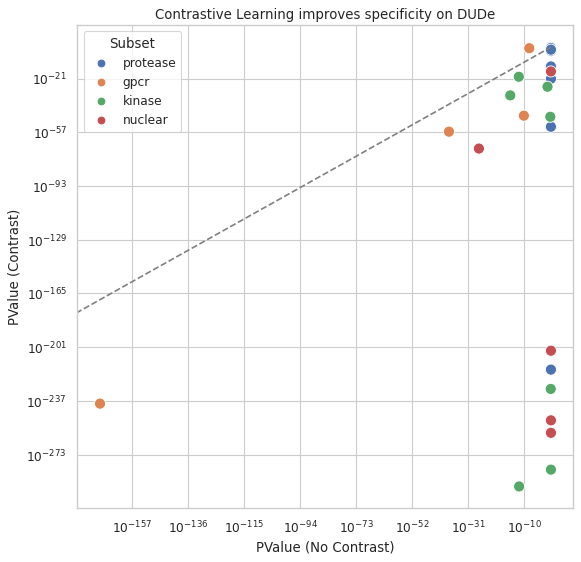

In [77]:
plt.figure(figsize=(8, 8), dpi=80)
sns.set(style="whitegrid", font_scale=1)

sns.scatterplot(data=arp_small,
                x="No Contrast",
                y="Contrast",
                hue="Subset",
                s=100,
               )
plt.plot([0,1],[0,1],linestyle="--",color="grey")
plt.xlabel("PValue (No Contrast)")
plt.ylabel("PValue (Contrast)")
plt.xscale("log")
plt.yscale("log")
plt.title("Contrastive Learning improves specificity on DUDe")
sns.despine()
plt.savefig("../img/dude_pval_scatterplot.png",bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
sns.set(style="whitegrid", font_scale=1)

sns.scatterplot(data=arp_small,
                x="No Contrast",
                y="Contrast",
                hue="Subset",
                s=100,
               )
plt.plot([0,1],[0,1],linestyle="--",color="grey")
plt.xlabel("PValue (No Contrast)")
plt.ylabel("PValue (Contrast)")
# plt.xscale("log")
# plt.yscale("log")
plt.title("Contrastive Learning improves specificity on DUDe")
plt.show()